<a href="https://colab.research.google.com/github/Riverag0011/ADS509-Text-Mining/blob/main/Assignment_6_Sentiment_GR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ADS 509 Sentiment Assignment

Name: Gabi Rivera \
Date: 130ct2024 \
Reference: "https://colab.research.google.com/" and "https://chatgpt.com/"


This notebook holds the Sentiment Assignment for Module 6 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required.

In a previous assignment you put together Twitter data and lyrics data on two artists. In this assignment we apply sentiment analysis to those data sets. If, for some reason, you did not complete that previous assignment, data to use for this assignment can be found in the assignment materials section of Blackboard.


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it.

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link.

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell.

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.*


In [1]:
import os
import re
#!pip install emoji
import emoji
import pandas as pd
import numpy as np

from collections import Counter, defaultdict
from string import punctuation
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
sw = stopwords.words("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Add any additional import statements you need here
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Location of the folder
data_location = "/content/drive/My Drive/M1 Results/"

# Define the folder paths
twitter_folder = os.path.join(data_location, "twitter/")
lyrics_folder = os.path.join(data_location, "lyrics/")

positive_words_file = "positive-words.txt"
negative_words_file = "negative-words.txt"
tidy_text_file = "tidytext_sentiments.txt"

## Data Input

Now read in each of the corpora. For the lyrics data, it may be convenient to store the entire contents of the file to make it easier to inspect the titles individually, as you'll do in the last part of the assignment. In the solution, I stored the lyrics data in a dictionary with two dimensions of keys: artist and song. The value was the file contents. A Pandas data frame would work equally well.

For the Twitter data, we only need the description field for this assignment. Feel free all the descriptions read it into a data structure. In the solution, I stored the descriptions as a dictionary of lists, with the key being the artist.

In [5]:
# Initialize dictionaries for lyrics
lyrics_list = []

# Read in the lyrics data
try:
    for artist in os.listdir(lyrics_folder):
        artist_folder = os.path.join(lyrics_folder, artist)
        if os.path.isdir(artist_folder):
            for song_file in os.listdir(artist_folder):
                if song_file.endswith('.txt'):
                    song_title = song_file.replace('.txt', '')
                    with open(os.path.join(artist_folder, song_file), 'r', encoding='utf-8') as f:
                        lyrics_content = f.read()
                        # Append a dictionary to the list
                        lyrics_list.append({'Artist': artist, 'Song Title': song_title, 'Lyrics': lyrics_content})
except FileNotFoundError:
    print("Lyrics folder not found. Please check the path.")

# Convert list to DataFrame
lyrics_df = pd.DataFrame(lyrics_list)

# Output DataFrame to check
lyrics_df.head()

,Artist,Song Title,Lyrics
0,robyn,robyn_bumpyride,"""Bumpy Ride""\n\n\n\nSometimes life can be a bu..."
1,robyn,robyn_inmyheart,"""In My Heart""\n\n\n\nHope things will get bett..."
2,robyn,robyn_youvegotthatsomething,"""You've Got That Something""\n\n\n\nLook at me ..."
3,robyn,robyn_doyouknowwhatittakes,"""Do You Know (What It Takes)""\n\n\n\nDon't you..."
4,robyn,robyn_thelasttime,"""The Last Time""\n\n\n\nEver since I was a litt..."


In [6]:
# Function to clean the song title
def clean_song_title(song_title):
    return song_title.split('_', 1)[1] if '_' in song_title else song_title

# Function to clean the lyrics
def clean_lyrics(lyrics):
    cleaned_lyrics = lyrics.split('\n\n\n\n', 1)[-1].strip()  # Keep only the part after the title
    cleaned_lyrics = cleaned_lyrics.replace('\n', ' ')  # Replace newlines with spaces
    return cleaned_lyrics.lower()  # Convert to lower case

# Apply the cleaning functions
lyrics_df['Clean Song Title'] = lyrics_df['Song Title'].apply(clean_song_title)
lyrics_df['Clean Lyrics'] = lyrics_df['Lyrics'].apply(clean_lyrics)

# Select only the relevant columns
cleaned_lyrics_df = lyrics_df[['Artist', 'Clean Song Title', 'Clean Lyrics']]

# Output the cleaned DataFrame
cleaned_lyrics_df.head()

,Artist,Clean Song Title,Clean Lyrics
0,robyn,bumpyride,sometimes life can be a bumpy ride sometimes i...
1,robyn,inmyheart,hope things will get better 'cause that's what...
2,robyn,youvegotthatsomething,look at me here i am i'm givin all of my lovin...
3,robyn,doyouknowwhatittakes,don't you know i can see what you're doing run...
4,robyn,thelasttime,ever since i was a little girl even younger th...


In [7]:
# List the Twitter files you want to read
twitter_files = [
    ('cher_followers_data.txt', 'cher'),
    ('robynkonichiwa_followers_data.txt', 'robyn')
]

# Function to read Twitter descriptions and output to a DataFrame
def read_twitter_descriptions(file_names):
    data = []  # List to store data for DataFrame

    for file_name, artist in file_names:
        try:
            # Read the file as plain text with UTF-8 encoding
            with open(os.path.join(twitter_folder, file_name), 'r', encoding='utf-8') as f:
                lines = f.readlines()

            # Extract the header and initialize column indices
            header = lines[0].strip().split('\t')
            if 'screen_name' in header and 'description' in header:
                screen_name_index = header.index('screen_name')
                description_index = header.index('description')
            else:
                print(f"'screen_name' or 'description' column not found in {file_name}.")
                continue

            # Collect screen names and descriptions from the subsequent lines
            for line in lines[1:]:
                columns = line.strip().split('\t')
                if len(columns) > max(screen_name_index, description_index):
                    screen_name = columns[screen_name_index]
                    description = columns[description_index]
                    data.append({'screen_name': screen_name, 'description': description, 'Artist': artist})

        except Exception as e:
            print(f"Error processing {file_name}: {e}")

    # Create a DataFrame from the collected data
    twitter_df = pd.DataFrame(data)
    return twitter_df

# Load descriptions from Twitter data
twitter_df = read_twitter_descriptions(twitter_files)

# Output the DataFrame to check
twitter_df.head()

,screen_name,description,Artist
0,horrormomy,𝙿𝚛𝚘𝚞𝚍 𝚜𝚞𝚙𝚙𝚘𝚛𝚝𝚎𝚛 𝚘𝚏 𝚖𝚎𝚜𝚜𝚢 𝚋𝚞𝚗𝚜 & 𝚕𝚎𝚐𝚐𝚒𝚗𝚐𝚜,cher
1,anju79990584,163㎝／愛かっぷ💜26歳🍒 工〇好きな女の子💓 フォローしてくれたらDMします🧡,cher
2,gallionjenna,csu,cher
3,bcscomm,Writer @Washinformer @SpelmanCollege alumna #D...,cher
4,Rodhandyjj,I’m unemployed and live with my parents. MOOPS!,cher


In [8]:
# Function to read positive and negative words
def read_sentiment_words(file_name, score):
    words = []
    try:
        with open(os.path.join('/content/', file_name), 'r', encoding='utf-8') as f:
            for line in f:
                line = line.strip()
                # Skip lines that are comments or empty
                if line and not line.startswith(';'):
                    words.append(line)
        return {word: score for word in words}
    except FileNotFoundError:
        print(f"File not found: {file_name}")
        return {}

# Specify filenames for sentiment words
positive_words_file = "positive-words.txt"
negative_words_file = "negative-words.txt"

# Load positive and negative words
positive_words = read_sentiment_words(positive_words_file, +1)
negative_words = read_sentiment_words(negative_words_file, -1)

# Combine positive and negative words into a single DataFrame
sentiment_words = {**positive_words, **negative_words}

# Convert to DataFrame
sentiment_df = pd.DataFrame(list(sentiment_words.items()), columns=['Word', 'Score'])

# Read in tidy text sentiments
tidy_text_file = "tidytext_sentiments.txt"
try:
    tidy_sentiments = pd.read_csv(os.path.join('/content/', tidy_text_file), sep='\t', encoding='utf-8')
except FileNotFoundError:
    print(f"File not found: {tidy_text_file}")
    tidy_sentiments = pd.DataFrame()

# Output the sentiment DataFrame to check
print("Sentiment DataFrame:\n", sentiment_df, "\n")
print("Tidy Text Sentiments DataFrame:\n", tidy_sentiments.head())

Sentiment DataFrame:
            Word  Score
0            a+      1
1        abound      1
2       abounds      1
3     abundance      1
4      abundant      1
...         ...    ...
6781       zaps     -1
6782     zealot     -1
6783    zealous     -1
6784  zealously     -1
6785     zombie     -1

[6786 rows x 2 columns] 

Tidy Text Sentiments DataFrame:
           word sentiment lexicon
0      abandon  negative     nrc
1    abandoned  negative     nrc
2  abandonment  negative     nrc
3         abba  positive     nrc
4    abduction  negative     nrc


## Sentiment Analysis on Songs

In this section, score the sentiment for all the songs for both artists in your data set. Score the sentiment by manually calculating the sentiment using the combined lexicons provided in this repository.

After you have calculated these sentiments, answer the questions at the end of this section.


In [9]:
# Create sentiment dictionary from sentiment_df
sentiment_dict = dict(zip(sentiment_df['Word'], sentiment_df['Score']))

# Function to calculate sentiment score for given lyrics text
def calculate_sentiment(lyrics, sentiment_dict):
    words = lyrics.lower().split()  # Split lyrics into words
    positive_count = sum(1 for word in words if word in sentiment_dict and sentiment_dict[word] == 1)
    negative_count = sum(1 for word in words if word in sentiment_dict and sentiment_dict[word] == -1)

    # Calculate sentiment score
    sentiment_score = positive_count - negative_count
    return sentiment_score

# Create a list to store results
results = []

# Iterate through the cleaned lyrics DataFrame
for index, row in cleaned_lyrics_df.iterrows():
    artist = row['Artist']
    song_title = row['Clean Song Title']
    lyrics = row['Clean Lyrics']
    score = calculate_sentiment(lyrics, sentiment_dict)

    results.append({
        'Artist': artist,
        'Song Title': song_title,
        'Lyrics': lyrics,
        'Sentiment Score': score,
        'Sentiment Category': 'Positive' if score > 0 else 'Negative' if score < 0 else 'Neutral'
    })

# Create a DataFrame with the results
lyrics_sentiment_df = pd.DataFrame(results)

# Output the sentiment DataFrame to check
lyrics_sentiment_df

,Artist,Song Title,Lyrics,Sentiment Score,Sentiment Category
0,robyn,bumpyride,sometimes life can be a bumpy ride sometimes i...,-1,Negative
1,robyn,inmyheart,hope things will get better 'cause that's what...,5,Positive
2,robyn,youvegotthatsomething,look at me here i am i'm givin all of my lovin...,5,Positive
3,robyn,doyouknowwhatittakes,don't you know i can see what you're doing run...,2,Positive
4,robyn,thelasttime,ever since i was a little girl even younger th...,12,Positive
...,...,...,...,...,...
415,cher,oogaboo,"ooga, ooga, ooga, ooga, ooga, ooga, ooga, boo ...",0,Neutral
416,cher,thegreatestthing,"[cher:] i don't know why you hurt inside, or w...",10,Positive
417,cher,walls,never thought that i would end up like this bu...,-11,Negative
418,cher,welcometoburlesque,"show a little more, show a little less, add a ...",1,Positive


In [10]:
# Group by artist and calculate the average sentiment score
average_sentiment_per_artist = lyrics_sentiment_df.groupby('Artist')['Sentiment Score'].mean().reset_index()

# Identify the artist with the highest average sentiment score
highest_sentiment_artist = average_sentiment_per_artist.loc[average_sentiment_per_artist['Sentiment Score'].idxmax()]

# Output the result
print(highest_sentiment_artist)

Artist                 cher
Sentiment Score    3.079114
Name: 0, dtype: object


In [11]:
# Specify the artist
artist1 = "cher"

# Filter the DataFrame for the specified artist
artist_songs = lyrics_sentiment_df[lyrics_sentiment_df['Artist'] == artist1]

# Get the three songs with the highest sentiment scores
highest_sentiments = artist_songs.nlargest(3, 'Sentiment Score')

# Get the three songs with the lowest sentiment scores
lowest_sentiments = artist_songs.nsmallest(3, 'Sentiment Score')

# Print the results
print("Highest Sentiment Songs:")
for index, row in highest_sentiments.iterrows():
    print(f"Title: {row['Song Title']}\nLyrics: {row['Lyrics']}\nSentiment Score: {row['Sentiment Score']}\n")

print("Lowest Sentiment Songs:")
for index, row in lowest_sentiments.iterrows():
    print(f"Title: {row['Song Title']}\nLyrics: {row['Lyrics']}\nSentiment Score: {row['Sentiment Score']}\n")

Highest Sentiment Songs:
Title: perfection
Lyrics: hush little baby, gotta be strong 'cause in this world we are born to fight be the best, prove them wrong a winner's work is never done, reach the top, number one  oh, perfection you drive me crazy with perfection i've worn my pride as my protection perfection, ohh  i was taught to be tough that the best that you can be ain't enough crack the whip, sacrifice but i found out paradise had a price  i didn't know it then, but oh i know it now you gotta work as hard as love to make the love work out you know this heart of mine has made some big mistakes i guess that when it comes to love, i just don't know what i takes  all my life i've been driven by perfection pushed it to the limit every day and night ohh, i've been driven by perfection but nothing's perfect when love ain't right nothing's perfect when the love ain't right  gave it all, played my part i gave everything i had but my heart worked so hard, made a name but the loneliness ins

In [12]:
# Specify the artist
artist2 = "robyn"

# Filter the DataFrame for the specified artist
artist_songs = lyrics_sentiment_df[lyrics_sentiment_df['Artist'] == artist2]

# Get the three songs with the highest sentiment scores
highest_sentiments = artist_songs.nlargest(3, 'Sentiment Score')

# Get the three songs with the lowest sentiment scores
lowest_sentiments = artist_songs.nsmallest(3, 'Sentiment Score')

# Print the results
print("Highest Sentiment Songs:")
for index, row in highest_sentiments.iterrows():
    print(f"Title: {row['Song Title']}\nLyrics: {row['Lyrics']}\nSentiment Score: {row['Sentiment Score']}\n")

print("Lowest Sentiment Songs:")
for index, row in lowest_sentiments.iterrows():
    print(f"Title: {row['Song Title']}\nLyrics: {row['Lyrics']}\nSentiment Score: {row['Sentiment Score']}\n")

Highest Sentiment Songs:
Title: loveisfree
Lyrics: free love is free, baby free love is free, baby boom boom boom boom boom chica boom let me give it to you, baby chica boom chica boom chica boom chica boom chica boom chica boom free love is free, baby free love is free, baby boom boom boom boom boom chica boom let me give it to you, baby  i'ma give it to you, baby i'ma give it when i'm ready some lose, some steady some light, some heavy it's all over this city sometimes in the ugly, sometimes in the pretty you never know where you get it cause you can't control it and you can't unfold it, slow down  i'ma give it to you, baby i'ma give it when i'm ready some lose, some steady some light, some heavy it's all over this city sometimes in the ugly, sometimes in the pretty you never know where you get it cause you can't control it and you can't unfold it, slow down  free love is free, baby free love is free, baby boom boom boom boom boom chica boom let me give it to you, baby yeah! yeah! ye

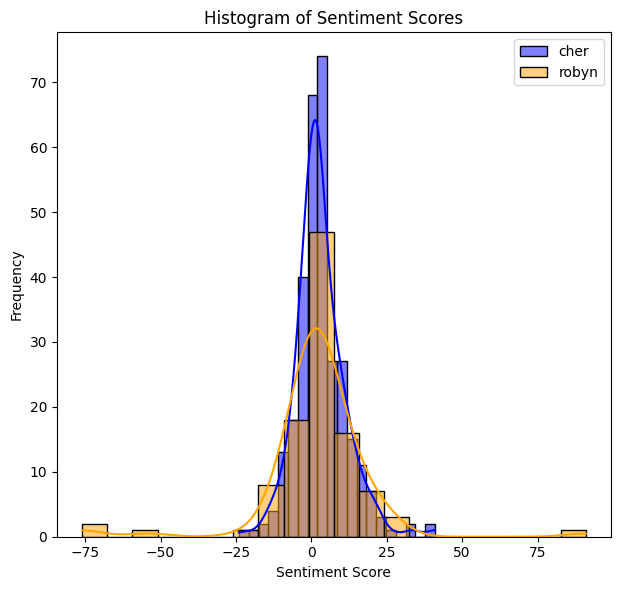

In [13]:
# Filter the DataFrame for each artist
artist1_scores = lyrics_sentiment_df[lyrics_sentiment_df['Artist'] == artist1]['Sentiment Score']
artist2_scores = lyrics_sentiment_df[lyrics_sentiment_df['Artist'] == artist2]['Sentiment Score']

# Set up the matplotlib figure
plt.figure(figsize=(12, 6))

# Plotting histograms for both artists
plt.subplot(1, 2, 2)
sns.histplot(artist1_scores, bins=20, color='blue', label=artist1, kde=True, alpha=0.5)
sns.histplot(artist2_scores, bins=20, color='orange', label=artist2, kde=True, alpha=0.5)
plt.title('Histogram of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

### Questions

Q: Overall, which artist has the higher average sentiment per song?

A: Cher has the higher average sentiment per song.

---

Q: For your first artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score?

A: I think it's the emotional words that might be driving the sentiment scores. For high positive songs, the word love is prevelent. For the lowest sentiment songs, words are more darker and focuses on rage/anger/betrayal.

---

Q: For your second artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score?

A: The same. Emotional words like pertaining to love are more prevalent in positive songs. Then for negative songs, words like "killing" and "criminal" dominates.

---

Q: Plot the distributions of the sentiment scores for both artists. You can use `seaborn` to plot densities or plot histograms in matplotlib.

The distribution confirms that cher has the highest frequency at the average sentiment score.



## Sentiment Analysis on Twitter Descriptions

In this section, define two sets of emojis you designate as positive and negative. Make sure to have at least 10 emojis per set. You can learn about the most popular emojis on Twitter at [the emojitracker](https://emojitracker.com/).

Associate your positive emojis with a score of +1, negative with -1. Score the average sentiment of your two artists based on the Twitter descriptions of their followers. The average sentiment can just be the total score divided by number of followers. You do not need to calculate sentiment on non-emoji content for this section.

In [14]:
# Define sets of emojis
positive_emojis = {'😀', '😊', '❤️', '👍', '🎉', '🌟', '😍', '💖', '🤗', '🙌', '💜',
                   '💓', '🧡', '✨', '😌', '⚡️', '🐝', '🙂', '🌹', '🌱', '🤯',
                   '💪', '💗', '😇', '☺️', '😍', '😎', '🥰', '👑', '💯', '🔥',
                   '💚', '😘', '💕', '💙', '😛', '😆', '🤭', '😃', '😋', '😙',
                   '😂', '💖', '😉', '🤗', '😝' '🤤', '🥳', '😝'}
negative_emojis = {'😢', '😡', '😞', '💔', '👎', '😩', '😤', '🤬', '😔', '😕',
                   '🧐', '😳', '❌', '🤢', '😨', '😓', '🤮', '😑', '😟', '😒',
                   '😪', '😬', '🥱', '🙄', '😵', '😦', '🤕', '😠', '😰', '💢',
                   '😧', '😞', '😖', '🤔', '🤨', '🥴', '😤', '😷', '🤧'}

# Create a dictionary to associate emojis with scores
emoji_scores = {emoji: 1 for emoji in positive_emojis}
emoji_scores.update({emoji: -1 for emoji in negative_emojis})

# Function to calculate emoji sentiment for a description
def calculate_emoji_sentiment(description):
    # Find all emojis in the description
    emojis_found = re.findall(r'[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F700-\U0001F77F\U0001F900-\U0001F9FF]', description)
    score = sum(emoji_scores.get(emoji, 0) for emoji in emojis_found)
    return score

# Calculate sentiment scores for each description and save to a new DataFrame
twitter_sentiment_df = twitter_df.copy()  # Create a copy of the original DataFrame
twitter_sentiment_df['Emoji Sentiment Score'] = twitter_sentiment_df['description'].apply(calculate_emoji_sentiment)

# Aggregate scores for each artist based on followers' descriptions
average_sentiment = twitter_sentiment_df.groupby('Artist')['Emoji Sentiment Score'].mean().reset_index()

# Display average sentiment scores
print(average_sentiment)

  Artist  Emoji Sentiment Score
0   cher               0.077302
1  robyn               0.037057


In [15]:
# Check scores and emoji identification
sampled_twitter_sentiment_df = twitter_sentiment_df.sample(n=10, random_state=100)
sampled_twitter_sentiment_df

,screen_name,description,Artist,Emoji Sentiment Score
822212,annefgaston,Anne vs Anne,cher,0
1793608,twwt2twwt,i follow back,cher,0
139076,thahoko,"Hi there, Twitter is using me. 🙂 | Digital Nomad",cher,1
729469,JohnnyF13491683,Sempre em busca de conhecimento.,cher,0
732574,mikaln,design enthusiast who crafts content for websi...,cher,0
103452,randywong,Computer Desktop Support Technician and Writer...,cher,0
1505876,Friendly__Songs,Personalized Custom Music CDs & Gifts: Retail/...,cher,0
1552624,mail_barbara,"R/A 14 yrs, , Mum of 2, step mum of 2, Nanna o...",cher,0
731127,hal_kolsky,American in the streets of London.,cher,0
1989849,peppermintash,🥰💙💍,cher,2


In [16]:
# Create a new column for emojis
twitter_sentiment_df['emojis'] = twitter_sentiment_df['description'].str.extract('([\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF\U0001F900-\U0001F9FF])')

# Remove rows with an Emoji Sentiment Score of 0
etwitter_df = twitter_sentiment_df[twitter_sentiment_df['Emoji Sentiment Score'] > 0]

# Display the cleaned DataFrame
etwitter_df

,screen_name,description,Artist,Emoji Sentiment Score,emojis
1,anju79990584,163㎝／愛かっぷ💜26歳🍒 工〇好きな女の子💓 フォローしてくれたらDMします🧡,cher,3,💜
27,bafwinn,BULLSHIT AF🔥,cher,1,🔥
43,adernworld_,level 17 wood elf ranger |🌹| filmmaker,cher,1,🌹
51,AIndividual2,🌹She/her🌹 🌹Social Democrat🌹 🌹Progress and Secu...,cher,8,🌹
67,boixgenius,🦢👑,cher,1,🦢
...,...,...,...,...,...
2190973,blairby,Ecologist 🌱 specialising in 🐦 & 🐬🐋 | Radical 🧚...,robyn,1,🌱
2191045,ANTHONYc,mostly not serious 👼🏽🌹✨,robyn,1,👼
2191064,joembo,"🌱Nanny, Mother, Disney Lover 🌱 💚May our hearts...",robyn,5,🌱
2191100,BirdOutTheBox,"Artist and promoter, NHS worker, progressive r...",robyn,1,😊


In [17]:
# Unique emojis
etwitter_df['emojis'].unique()

array(['💜', '🔥', '🌹', '🦢', '😎', '💕', '💖', '🐝', '😭', '🙌', '🐈', '📚', '💙',
       '🦖', '🥰', '😀', '💯', '🖤', '🌲', '🌱', '🏳', '🏽', '😍', '😂', '🌎', '🎨',
       '🏻', '😈', '🌊', '💗', '🌻', '😊', '🦋', '💚', '😄', '💨', '👀', '😝', '💓',
       '🌸', '🐯', '🤯', '💪', '🏈', '😘', '🧝', '🏦', '📦', '😌', '🍀', '🤗', '🔛',
       '🌺', '🧜', '🧡', '🌈', '👑', '🏒', '📖', '😺', '🌟', '👊', '🍑', '🦄', '🤓',
       '🏼', '🍯', '👉', '🦇', '🧃', '🤍', '🎶', '🔈', '😋', '👾', '💥', '🖕', '🌙',
       '🌌', '🍃', '😇', '🤟', '🙏', '🌇', '🎉', '🔞', '🏹', '👩', '😉', '🚀', '🎥',
       '🥧', '🎹', '🌿', '👍', '💛', '🎧', '🙂', '🏥', '🧩', '😛', '🐚', '🌍', '🏴',
       '👆', '🎭', '🧂', '👸', '🗽', '🎷', '🤘', '😐', '🚫', '💋', '😃', '💞', '💔',
       '🥳', '📍', '🤩', '🏿', '🦀', '🎬', '💉', '🗳', '🛬', '🤭', '🎙', '💎', '🎓',
       '😆', '🍒', '😁', '😙', '🐾', '🐱', '🐶', '🕺', '🥀', '🧠', '🥃', '🔴', '💑',
       '📝', '🧧', '🍷', '🤫', '🏆', '💇', '😜', '😗', '💫', '👧', '🦁', '🎀', '🙅',
       '🙈', '💐', '📺', '🍊', '🦈', '🧘', '🛫', '🤎', '🍭', '🐦', '👹', '🧉', '🥵',
       '🎵', '🎮', '🐠', '🎗', '🤖', '👼', '🦸', '👷', '🤣', '🐆', '🐉', '🏖

In [18]:
# Define sets of emojis
positive_emojis = ['😀', '😊', '❤️', '👍', '🎉', '🌟', '😍', '💖', '🤗', '🙌', '💜',
                   '💓', '🧡', '✨', '😌', '⚡️', '🐝', '🙂', '🌹', '🌱', '🤯',
                   '💪', '💗', '😇', '☺️', '😍', '😎', '🥰', '👑', '💯', '🔥',
                   '💚', '😘', '💕', '💙', '😛', '😆', '🤭', '😃', '😋', '😙',
                   '😂', '💖', '😉', '🤗', '😝' '🤤', '🥳', '😝']
negative_emojis = ['😢', '😡', '😞', '💔', '👎', '😩', '😤', '🤬', '😔', '😕',
                   '🧐', '😳', '❌', '🤢', '😨', '😓', '🤮', '😑', '😟', '😒',
                   '😪', '😬', '🥱', '🙄', '😵', '😦', '🤕', '😠', '😰', '💢',
                   '😧', '😞', '😖', '🤔', '🤨', '🥴', '😤', '😷', '🤧']

# Count emojis for each artist
emoji_counts = etwitter_df.groupby(['Artist', 'emojis']).size().reset_index(name='counts')

# Filter for positive and negative emojis
positive_counts = emoji_counts[emoji_counts['emojis'].isin(positive_emojis)]
negative_counts = emoji_counts[emoji_counts['emojis'].isin(negative_emojis)]

# Find the most popular positive emoji for each artist
most_popular_positive = positive_counts.loc[positive_counts.groupby('Artist')['counts'].idxmax()]

# Find the most popular negative emoji for each artist
most_popular_negative = negative_counts.loc[negative_counts.groupby('Artist')['counts'].idxmax()]

# Display the results
print("Most Popular Positive Emoji:")
print(most_popular_positive)

print("\nMost Popular Negative Emoji:")
print(most_popular_negative)

Most Popular Positive Emoji:
     Artist emojis  counts
379    cher      💙    7192
1159  robyn      💙     285

Most Popular Negative Emoji:
     Artist emojis  counts
620    cher      😷      28
1154  robyn      💔       2


Q: What is the average sentiment of your two artists?

A: The average emoji sentiment for cher is 7.7% and for robyn, it's 3.7%.

---

Q: Which positive emoji is the most popular for each artist? Which negative emoji?

A: It seems that both of them have the same emojis that are most popular for positive 💙 and for negative, cher has 😷 and robyn has 💔.
